# Аугментация с заменой слов на основе word2vec (2 балла)

In [13]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [39]:
!pip install wget
import wget

In [ ]:
!wget -c http://vectors.nlpl.eu/repository/20/180.zip
!unzip 180.zip

--2020-11-08 15:19:58--  http://vectors.nlpl.eu/repository/20/180.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484452317 (462M) [application/zip]
Saving to: ‘180.zip’

180.zip             100%[===================>] 462.01M  9.88MB/s    in 61s     

2020-11-08 15:21:01 (7.59 MB/s) - ‘180.zip’ saved [484452317/484452317]

Archive:  180.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [ ]:
!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 8.2MB 5.7MB/s 


In [40]:
import gensim

!pip install razdel
from razdel import tokenize

In [ ]:
!pip install ufal.udpipe
from ufal.udpipe import Model, Pipeline
import os
import re
import sys

     |████████████████████████████████| 307kB 2.5MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625277 sha256=6e5929fa58a573997e9a3e2f43b43da1201761378e667d468d7e61e9b264b914
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
Successfully built ufal.udpipe


In [ ]:
!pip install razdel
!pip install pymorphy2

from razdel import tokenize
from razdel import sentenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  
nltk.download('punkt')
from string import punctuation
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
punctuation = punctuation + '„“«»'

In [ ]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format("model.bin", binary=True)

word_vectors.init_sims(replace=True) # it is beneficial to normalize the word2vec vectors first, so they all have equal length

In [ ]:
udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
udpipe_filename = udpipe_model_url.split('/')[-1]
wget.download(udpipe_model_url)
model = Model.load('udpipe_syntagrus.model')
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

In [ ]:
def clean_token(token, misc):
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma

def process(text, keep_pos=True, keep_punct=False):
    pipeline = process_pipeline
    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

In [ ]:
def tokenizing(text):

  tokens = list(tokenize(text))
  tokens = [_.text for _ in tokens]
  # tokens = [word.lower() for word in tokens if word.lower() not in russian_stopwords]
  tokens = [(word.translate(str.maketrans('', '', punctuation))) for word in tokens]
  tokens = [token.lower() for token in tokens if token != '']

  return tokens

In [ ]:
def make_grammar(result: list,tokens: list):
  
  grammar_phrase = []

  poses = ['NOUN', 'NPRO', 'ADJF', 'ADJS', 'INFN', 'VERB',
             'PRTF', 'PRTS', 'GRND', 'NUMR', 'ADVB']

  if len(result) == len(tokens):
    for i,el in enumerate(result):
      morph_input = morph.parse(tokens[i])[0]
      morph_output = morph.parse(result[i])[0]
      p = morph_input
      tags = [morph_input.tag.gender, morph_input.tag.number,
              morph_input.tag.case, morph_input.tag.tense,
              morph_input.tag.mood, morph_input.tag.person]
      if p.tag.POS == 'NOUN':
        # не будем пытаться приписывать существительному гендер, к которому оно не принадлежит
        tags_input = set([tag for tag in tags[1:] if tag != None])
      else:
        tags_input = set([tag for tag in tags if tag != None])
      try: 
        grammar_word = morph_output.inflect(tags_input).word
      except AttributeError:
        grammar_word = p.word

      grammar_phrase.append(grammar_word)
  else:
    grammar_phrase = tokens



  return " ".join(grammar_phrase)

# к сожалению, вместо наречий всегда будут существительные в начальных формах, т.к
# Parse(word='вечером', tag=OpencorporaTag('ADVB'), normal_form='вечером', score=0.882882, methods_stack=((DictionaryAnalyzer(), 'вечером', 3, 0),))
# из NOUN нельзя сделать ADVB в inflect()

In [ ]:
# функция заменяет слова во входном предложении их ближайшими семантическими ассоциатами 

def augment_word2vec(sentence, model):
    tokens = tokenizing(sentence) 
    tokens_pos = process(text=sentence)
    result = []
    for word in tokens_pos:
        pos = word.split('_')[1]
        try:
          result.append(model.similar_by_word(word)[0][0])
        # на предлогах падает, так как не находит синонимов
        except KeyError:
          result.append(word.split('_')[0])

    result = [x.split('_')[0] for x in result] # -> слова, которые нужно поставить в нужную форму = полученный синоним в начальной форме

    return make_grammar(result,tokens)


# немного Есенина
sentence = """И надо мной звезда горит,
              Но тускло светится в тумане,
              И мне широкий путь лежит,
              Но он заросший весь в бурьяне."""

augment_word2vec(sentence,model = word_vectors) # -> и надо мной небосвод пылает но тусклый мерцает в мгле и мне узкий путь лежит но он зараставший весь в крапиве

'и надо мной небосвод пылает но тусклый мерцает в мгле и мне узкий путь лежит но он зараставший весь в крапиве'

# Блок 2: Регрессия; Medium Stories (до 8 баллов)

Датасет можно скачать [здесь](https://yadi.sk/d/90JykTO48fL6qw) или со страницы кегли. Можно взять подвыборку.



Подзадачи:

1.   Эксплоративный анализ данных (1 балл)
2.   Отбор важных признаков, поиск гиперпараметров, минимизация переобучения (2 балла)
3.   Адаптация аугментации данных с заменой слов (1 балл)
4.   Конструирование текстовых признаков (2 балла)
5.   Сравнение качества моделей, выбор наилучшей (1 балл)
6.   Анализ ошибок (1 балл)  

In [5]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# можно не использовать колонки с тегами
usecols = ["Title", "Subtitle", "Image", "Author", "Publication", "Year", "Month", "Day", "Reading_Time", "Claps", "url", "Author_url"]

data = pd.read_csv("/content/drive/My Drive/PROGA/4_year/hw4/Medium_Clean.csv", sep=",", usecols=usecols)
data["Claps"] = data["Claps"].astype(int)
data.head(2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,url,Author_url
0,Online Animation: Mixamo vs Norah AI,Online animations tools provide game designers...,1,Emma Laurent,NaN,2017,8,1,5,12,https://medium.com/@laurentemma/online-animati...,https://medium.com/@laurentemma
1,A.I. ?,NaN,0,Sanparith Marukatat,NaN,2017,8,1,2,11,https://medium.com/@sanparithmarukatat/a-i-%E0...,https://medium.com/@sanparithmarukatat


In [7]:
data = data.dropna()

### Эксплоративный анализ данных. Посмотрим, например, на зависимость выхода статьи от месяца, а также на среднюю продолжительность чтения статей.

In [34]:
data.describe()

,Image,Year,Month,Day,Reading_Time,Claps
count,271011.000000,271011.000000,271011.000000,271011.000000,271011.000000,271011.000000
mean,0.671113,2017.590197,6.460033,15.659674,3.975400,217.876809
std,0.469810,0.491798,3.430337,8.822305,3.256406,1500.161247
min,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2017.000000,3.000000,8.000000,2.000000,0.000000
50%,1.000000,2018.000000,6.000000,16.000000,3.000000,19.000000
75%,1.000000,2018.000000,9.000000,23.000000,5.000000,128.000000
max,1.000000,2018.000000,12.000000,31.000000,207.000000,291000.000000


[(106866, '8 / 2017'), (108412, '9 / 2017'), (115141, '10 / 2017'), (110957, '11 / 2017'), (104165, '12 / 2017'), (120020, '1 / 2018'), (109261, '2 / 2018'), (124000, '3 / 2018'), (120579, '4 / 2018'), (121348, '5 / 2018'), (118283, '6 / 2018'), (127299, '7 / 2018'), (4702, '8 / 2018')]
['8 / 2017', '9 / 2017', '10 / 2017', '11 / 2017', '12 / 2017', '1 / 2018', '2 / 2018', '3 / 2018', '4 / 2018', '5 / 2018', '6 / 2018', '7 / 2018', '8 / 2018']
[106866, 108412, 115141, 110957, 104165, 120020, 109261, 124000, 120579, 121348, 118283, 127299, 4702]


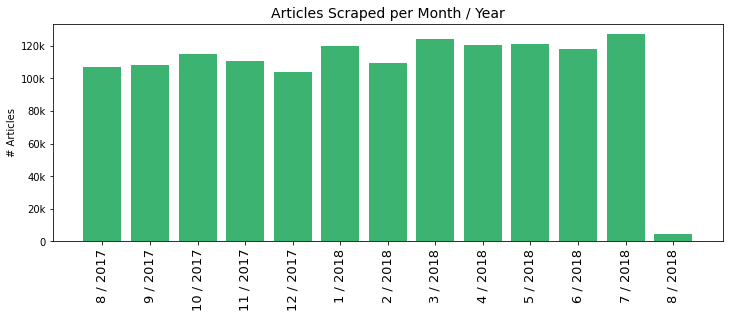

In [31]:
# Посмотрим, какое количество текстов было опубликовано в разное время (каждый месяц за эти два года)

years = list(data.Year.unique())
months = list(data.Month.unique())

d = []

for year in years:
    for month in sorted(months):
        counts = data[(data.Year==year)&(data.Month==month)].shape[0]
        date = str(month)+" / "+str(year)
        if counts != 0:
            d.append((counts,date))

print(d)
x = [x[1] for x in d]
y = [y[0] for y in d]
print(x)
print(y)

plt.figure(figsize=(12,4))
plt.bar(x, y, color = "mediumseagreen")
plt.title("Articles Scraped per Month / Year", fontsize=14)
plt.ylabel("# Articles")
plt.yticks([0,20000,40000,60000,80000,100000,120000],
           ["0", "20k","40k","60k","80k","100k", "120k"])
plt.xticks(rotation=90, fontsize=13)
plt.show()

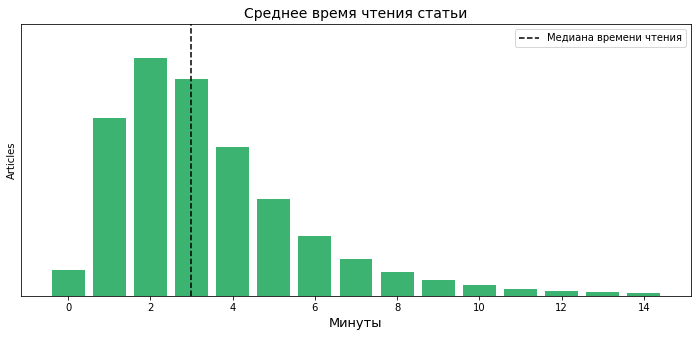

In [32]:
# Сколько времени уходит в среднем на статью

avs=[]
medians=[]
total_cs = []
readts=[]
entries = []
for x in range(15):
    medians.append(data[data.Reading_Time==x].Claps.quantile(q=0.5))
    readts.append(x)
    entries.append(data[data.Reading_Time==x].shape[0])
    total_cs.append(data[data.Reading_Time==x].Claps.sum())

plt.figure(figsize=(12,5))
plt.bar(readts,entries, color="mediumseagreen")
plt.vlines(data.Reading_Time.median(),0,350000,
           color="black",
           linestyle="dashed",
           label="Медиана времени чтения")
plt.title("Среднее время чтения статьи", fontsize=14)
#plt.yticks([0,100000,200000,300000], ["0","100k", "200k", "300k"])
plt.yticks([])
plt.ylim(0,350000)
plt.ylabel("Articles")
plt.xlabel("Минуты", fontsize=13)
plt.legend()

plt.show()

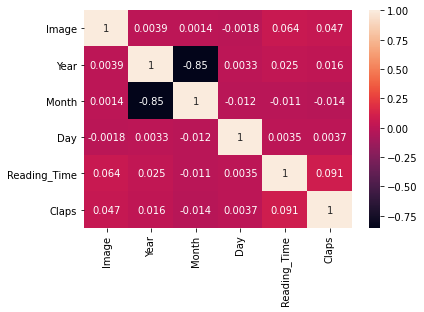

In [35]:
# Посмотрим корреляцию
sns.heatmap(data.corr(), annot=True)

# Видно, что на лайки влияет время чтения статьи 

### Для конструирования текстовых признаков возьмем
1. Количество предложений
2. Количество токенов
3. Количество стоп слов
4. Количество сущностей

In [10]:
# Для обучения возьмем title и subtitle, каждый из них очень маленький

title = list(data['Title'])
subtitle = list(data['Subtitle'])

texts = []
for i,el in enumerate(title):
  text = str(title[i]) + '. ' +  str(subtitle[i])
  texts.append(text)

data['texts'] = texts

In [ ]:
# Gensim
import gensim
from gensim.utils import simple_preprocess

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


def eng_preprocessing(text):
    # Tokenization + lowercase + remove punctiation
    text = gensim.utils.simple_preprocess(str(text), deacc=True)
    
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    
    
    return text

texts = list(data['texts'])

In [17]:
import gensim
from gensim.utils import simple_preprocess

In [18]:
data['len_tokens'] = [len(eng_preprocessing(text)) for text in texts]
data.head(2)

,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,url,Author_url,texts,len_tokens
3,The Value Generated through AI led Mindfulness,A true product co-created by the Millennials,1,Emiko Sawaguchi,MILLENNIALSTIMES,2017,8,1,5,4,https://millennials-times.com/creativeflower-e...,https://millennials-times.com/@emikosawaguchi,The Value Generated through AI led Mindfulness...,10
4,"Os Melhores Links de JulhoCmeras Vintage, Goog...",mas pera a?,1,Giovani Ferreira,NEW ORDER,2017,8,1,3,56,https://medium.com/neworder/os-melhores-links-...,https://medium.com/@gferreira,"Os Melhores Links de JulhoCmeras Vintage, Goog...",13


In [19]:
from nltk.tokenize import sent_tokenize
data['len_sents'] = [len(sent_tokenize(text)) for text in texts]

In [20]:
data.len_sents.value_counts()

2     190348
3      52347
4      16351
1       5446
5       4634
6       1295
7        365
8        129
9         50
10        24
11         7
12         6
13         5
17         2
14         2
Name: len_sents, dtype: int64

In [21]:
stops = []
for text in texts:
  i = 0
  tokens = gensim.utils.simple_preprocess(str(text), deacc=True)
  for token in tokens:
    if token in stop_words:
      i+=1
  stops.append(i)
      
data['stops'] = stops

In [22]:
data.head(2)

,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,url,Author_url,texts,len_tokens,len_sents,stops
3,The Value Generated through AI led Mindfulness,A true product co-created by the Millennials,1,Emiko Sawaguchi,MILLENNIALSTIMES,2017,8,1,5,4,https://millennials-times.com/creativeflower-e...,https://millennials-times.com/@emikosawaguchi,The Value Generated through AI led Mindfulness...,10,2,4
4,"Os Melhores Links de JulhoCmeras Vintage, Goog...",mas pera a?,1,Giovani Ferreira,NEW ORDER,2017,8,1,3,56,https://medium.com/neworder/os-melhores-links-...,https://medium.com/@gferreira,"Os Melhores Links de JulhoCmeras Vintage, Goog...",13,2,0


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

In [ ]:
from tqdm import tqdm 

ner = []
for text in tqdm(texts):
  i = 0
  for sent in nltk.sent_tokenize(text):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
      if hasattr(chunk, 'label'):
        i+=1
  ner.append(i)

len(ner)

# очень долго работает, если не забуду, в конце сделаю
# data['ner'] = ner

### Адаптация аугментации данных с заменой слов

In [ ]:
!wget -c http://vectors.nlpl.eu/repository/20/5.zip

In [ ]:
!unzip -q '/content/5.zipny'

In [ ]:
nltk.download('wordnet')

In [91]:
model_eng = gensim.models.KeyedVectors.load_word2vec_format("model.bin", binary=True)
model_eng.init_sims(replace=True)

In [ ]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def augment_word2vec_eng(sentence, model=model_eng):

    tokens = gensim.utils.simple_preprocess(str(sentence), deacc=True)
    new_sent = []
    for token in tokens:
        lem = lemmatizer.lemmatize(token)
        if lem in model:
            new_token = model.most_similar(lem)[0]
            new_sent.append(str(new_token[0]))
        else:
            new_sent.append(str(token)) 
    return new_sent


In [ ]:
# возьмем только 1000 текстов для аугментации, функция долго работает
aug_texts = []
for text in tqdm(texts[:1000]):
  aug_texts.append(augment_word2vec_eng(text))

### Отбор важных признаков, поиск гиперпараметров, минимизация переобучения (2 балла)

In [29]:
data.head(2)

,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,url,Author_url,texts,len_tokens,len_sents,stops
3,The Value Generated through AI led Mindfulness,A true product co-created by the Millennials,1,Emiko Sawaguchi,MILLENNIALSTIMES,2017,8,1,5,4,https://millennials-times.com/creativeflower-e...,https://millennials-times.com/@emikosawaguchi,The Value Generated through AI led Mindfulness...,10,2,4
4,"Os Melhores Links de JulhoCmeras Vintage, Goog...",mas pera a?,1,Giovani Ferreira,NEW ORDER,2017,8,1,3,56,https://medium.com/neworder/os-melhores-links-...,https://medium.com/@gferreira,"Os Melhores Links de JulhoCmeras Vintage, Goog...",13,2,0


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# X = data.drop(columns = ['Claps'])
# y = data['Claps']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
tokens = [' '.join(eng_preprocessing(text)) for text in texts]

In [32]:
data['tokens'] = tokens

In [33]:
train, test = train_test_split(data, train_size=0.8, shuffle=True, random_state=42)

In [34]:
print(train.shape, test.shape)

(216808, 17) (54203, 17)


In [35]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(train['tokens'])

In [36]:
X.shape

(216808, 1000)

In [37]:
X.toarray().shape

(216808, 1000)

In [43]:
X_train = np.concatenate((X.toarray(), train[['len_tokens', 'len_sents', 'Reading_Time', 'stops', 'Image']].to_numpy()), axis=1)

In [44]:
X_train.shape

(216808, 1005)

In [45]:
X_test = np.concatenate((vectorizer.transform(test['tokens']).toarray(), test[['len_tokens', 'len_sents', 'Reading_Time', 'stops', 'Image']].to_numpy()), axis=1)
X_test.shape

(54203, 1005)

In [46]:
y_train = train['Claps']
y_test = test['Claps']

In [47]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  f1_score
folds = KFold(n_splits=4, shuffle=True, random_state=42)

In [48]:
cls = LinearRegression().fit(X_train, y_train)
cls.score(X_test,y_test)

0.013409791388980019

In [49]:
# Lasso = Linear Model trained with L1 prior as regularizer
from sklearn import linear_model
clf = linear_model.Lasso()
clf.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [53]:
def scores(model):
    print('Accuracy: ', round(model.score(X_test, y_test),4))
    y_score = model.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)
    print(f'Precision: {average_precision}')
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    print(f'Recall: {recall}')
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {round(f1,4)}')

In [55]:
print('Accuracy: ', round(clf.score(X_test, y_test),4))

Accuracy:  0.0099


# Блок 3: Paraphrase Detection (до 8 баллов)


* [Статья по русскоязычному корпусу парафразов](https://www.aclweb.org/anthology/2020.ngt-1.6/)
* [Еще статья](http://www.dialog-21.ru/media/3928/loukachevitchnvetal.pdf)
* [Сайт корпуса](http://paraphraser.ru/)

Отформатированные данные можно скачать [здесь](https://yadi.sk/d/OIgbnRA6OVJ4VQ)


1.   Эксплоративный анализ данных (1 балл)
2.   Поиск гиперпараметров, минимизация переобучения (2 балла)
3.   Аугментация данных (1 балл)
4.   Сравнение качества моделей, выбор наилучшей (1 балл)
5.   Конструирование текстовых признаков (2 балла)
6.   Анализ ошибок (1 балл)



In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("/content/paraphrases.tsv", sep="\t")
data.head(3)

,text_1,text_2,class
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1


In [ ]:
data['class'].value_counts(normalize=True)

-1    0.604684
 1    0.395316
Name: class, dtype: float64

In [ ]:
sentence_1 = process(list(data.text_1)[5])
sentence_2 = process(list(data.text_2)[5]) 

similarity = word_vectors.wmdistance(sentence_1, sentence_2)
print("{:.4f}".format(similarity))

1.0546


### В рамках эксплоративного анализа данных, попробуем посчитать векторное расстояние для обоих классов и построить график

In [ ]:
from numpy import inf
from tqdm import tqdm

sim = []
text_1 = list(data.text_1)
text_2 = list(data.text_2)
for i in tqdm(range(len(text_1))):
  try:
    sentence_1 = process(text_1[i])
    sentence_2 = process(text_2[i])
    similarity = word_vectors.wmdistance(sentence_1, sentence_2)
    # if one of the documents have no words that exist in the Word2Vec vocab, float(‘inf’) (i.e. infinity) will be returned.
    if similarity == inf:
      sim.append(None)
    else:
      sim.append(similarity)
  except NameError:
    sim.append(None)

data['similarity'] = sim

100%|██████████| 8540/8540 [02:05<00:00, 68.02it/s]


In [ ]:
# смотрим, есть ли NaN значения, и удаляем их

for col_name in data.columns:
    num_nan_values = len(data[data[col_name].isna()])
    print("Number of NaN values in %s column is %d" % (col_name, num_nan_values))
    if num_nan_values > 0:
        data = data.dropna(subset=[col_name])

print()
print("Total number of rows is %d" % data.shape[0])

Number of NaN values in text_1 column is 0
Number of NaN values in text_2 column is 0
Number of NaN values in class column is 0
Number of NaN values in similarity column is 1798

Total number of rows is 6742


In [ ]:
sim_1 = data[data['class'] == 1]['similarity']
sim_2 = data[data['class'] == -1]['similarity']

print(len(sim_1),len(sim_2))
data['class'].value_counts(normalize=True)

2762 3980


-1    0.590329
 1    0.409671
Name: class, dtype: float64

In [ ]:
print(sim_1.mean(),sim_2.mean())

0.4433155406557328 0.9257151321079744


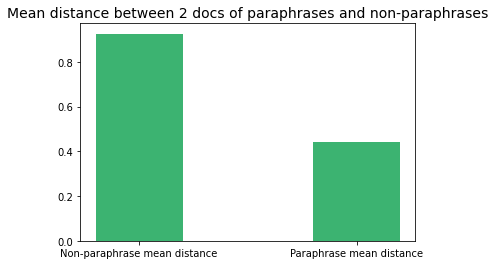

In [ ]:
t = [sim_1.mean(), sim_2.mean()]
s = [1,-1]

# Make a fake dataset:
height = [0.4433155406557328, 0.9257151321079744]
bars = ['Paraphrase mean distance', 'Non-paraphrase mean distance']
y_pos  = [1,-1]
 
plt.title("Mean distance between 2 docs of paraphrases and non-paraphrases", fontsize=14)

# Create bars
plt.bar(y_pos, height, color = "mediumseagreen")
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()
 

# Как и ожидалось, на графике видно, что для парафраз векторное расстояние в два раза меньше, чем для других текстов 

###  Аугментация данных

In [ ]:

sentence = list(data.text_1)[14]
print(sentence)
print(augment_word2vec(sentence,model = word_vectors))

Убийство московского чиновника в Орле было заказным.
преступление нижегородского чиновника в белгороде было заказным


In [ ]:
text_1 = list(data.text_1)
text_1_aug = []
for text in tqdm(text_1):
  text_1_aug.append(augment_word2vec(text, model = word_vectors))
data['text_1_aug'] = text_1_aug 

100%|██████████| 6742/6742 [18:36<00:00,  6.04it/s]


In [ ]:
text_2 = list(data.text_2)
text_2_aug = []
for text in tqdm(text_2):
  text_2_aug.append(augment_word2vec(text, model = word_vectors))
data['text_2_aug'] = text_2_aug 

100%|██████████| 6742/6742 [17:05<00:00,  6.57it/s]


In [ ]:
data.head(2)

,text_1,text_2,class,similarity,text_1_aug,text_2_aug
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1,0.193815,комитет юстиции аргентины узаконивал лесбийски...,комитет юстиции аргентины разрешил лесбийские ...
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1,1.268759,магнит поручится перед брахман банком за ссуду...,производство сигареток в страны упал изза анти...


### Для конструирования текстовых признаков возьмем
1. Количество предложений
2. Количество токенов
3. Количество стоп слов
4. Количество сущностей
5. IPM

In [ ]:
from razdel import tokenize

def len_tokens(texts: list):
  lens = []
  stops = []
  for text in texts:
    tokens = list(tokenize(text))
    tokens = [_.text for _ in tokens]
    tokens = [x for x in tokens if x not in punctuation]
    lens.append(len(tokens))
    stop = [x for x in tokens if x in russian_stopwords]
    stops.append(len(stop))

  return lens, stops

data['len_tokens_1'] = len_tokens(text_1)[0]
data['len_tokens_2'] = len_tokens(text_2)[0]

data['stops_1'] = len_tokens(text_1)[1]
data['stops_2'] = len_tokens(text_2)[1]

In [ ]:
from razdel import sentenize

def len_sent(texts: list):
  lens = []
  for text in texts:
    sent = list(sentenize(text))
    sent = [_.text for _ in sent]
    lens.append(len(sent))

  return lens

data['len_sent_1'] = len_sent(text_1)
data['len_sent_2'] = len_sent(text_2)

In [ ]:
# Это оказалось не очень эффективно, так как почти все тексты по одному предложению
data.len_sent_1.value_counts()

1    6738
2       4
Name: len_sent_1, dtype: int64

In [ ]:
!wget http://dict.ruslang.ru/Freq2011.zip
!unzip -q '/content/Freq2011.zip'

In [ ]:
def build_dict(freq_dict_path):
    freq = pd.read_csv(freq_dict_path, sep="\t")
    freq_dict = dict(
        zip(
            freq["Lemma"].tolist(), freq["Freq(ipm)"].tolist()
        )
    )
    freq_dict = {k: float(v) for k, v in freq_dict.items()}
    return freq_dict


freq_dict = build_dict(freq_dict_path="freqrnc2011.csv")

def ipm(text, freq_dict=freq_dict, morph=morph):
    lemmas = []
    for token in tokenize(text):
        token = token.text
        if token in punctuation:
            continue
        lemma = morph.parse(token)[0].normal_form
        if not re.match("\W+", lemma):
            lemmas.append(lemma)
    return sum([True for w in lemmas if w in freq_dict and freq_dict[w] > 1]) / len(lemmas) if lemmas else 0

In [ ]:
data['ipm_1'] = [ipm(x) for x in text_1]
data['ipm_2'] = [ipm(x) for x in text_2]

In [ ]:
!pip install --quiet natasha

import natasha
import pandas as pd

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    
    PER,
    DatesExtractor,
    NamesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

In [ ]:
morph_vocab = MorphVocab()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)
dates_extractor = DatesExtractor(morph_vocab)
names_extractir = NamesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [ ]:
from tqdm.auto import tqdm

def preprocess_with_natasha(text: str) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)

    return len(doc.spans)

data['len_ner_1'] = [preprocess_with_natasha(text) for text in text_1]
data['len_ner_2'] = [preprocess_with_natasha(text) for text in text_2]

In [ ]:
data.head()

,text_1,text_2,class,similarity,text_1_aug,text_2_aug,len_tokens_1,len_tokens_2,len_sent_1,len_sent_2,stops_1,stops_2,ipm_1,ipm_2,len_ner_1,len_ner_2
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1,0.193815,комитет юстиции аргентины узаконивал лесбийски...,комитет юстиции аргентины разрешил лесбийские ...,6,6,1,1,0,0,0.833333,0.833333,2,2
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1,1.268759,магнит поручится перед брахман банком за ссуду...,производство сигареток в страны упал изза анти...,11,8,1,1,3,1,0.636364,0.750000,2,1
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1,0.393186,евросоюза призвал сшаотретей не разбомбить лив...,ес призвал сшаотретей ждать доклада совет::без...,10,8,1,1,2,1,0.500000,0.500000,4,4
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1,0.687627,изделие нижегородского подземки воочию перейдё...,собственности фирмы воочию отдадут депо в ниже...,8,8,1,1,1,1,1.000000,1.000000,2,0
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1,0.658243,два человека гибли в столкновениях между курдс...,один человек гиб при столкновении судов в бере...,9,9,1,1,3,2,0.888889,0.888889,1,1
